I don't know why this is necessary, but it sometimes helps after changing the package. \<br> It refreshes the python cache.

In [1]:
rm -rf my_package/__pycache__

In [2]:
import sys
import os

# Go up one directory from the 'notebooks' folder.
parent_dir = os.path.abspath(os.path.join('..'))
sys.path.append(parent_dir)

from my_package.module import *
from my_package.pulse_manager import *
import numpy as np
from qutip import *
import dynamiqs as dq
import boulderopal as bo
import qctrlvisualizer as qv

Boulder Opal client update available.
Latest version is 2.2.0, you have 2.1.3.
Visit https://docs.q-ctrl.com/boulder-opal/changelog for the latest product updates.


<img src="/Users/seungwonjin/Library/Mobile Documents/com~apple~CloudDocs/Codespace/Oscillator_seungwon/figures/SNAP_numberFock_PRL.png" alt="My Image" width="800">

## Define system parameters

In [3]:
# SNAP gate: PRL 115, 137002 (2015)
# stroage cavity, qubit(transmon)
dim_c= 10
dim_q= 5
# energies
w_c = (2*np.pi)*8226.787e6
w_q = (2*np.pi)*7527.05e6
# self-Kerr
K_c = (2*np.pi)*(-106.2e3)
K_q = (2*np.pi)*283.4e6
# coupling strength
chi_cq = (2*np.pi)*(-8273e3)
# relaxation rate
kappa_c = 1/50e6
kappa_q = 1/21e6

# Hamiltonian
H0, c_ops, H_drive_cavity, H_drive_qubit = Hamiltonian_dispersive(dim_c, dim_q, w_c, w_q, K_c, K_q, chi_cq, kappa_c, kappa_q, plotter=False)
# H0, c_ops, H_drive_cavity, H_drive_qubit = Hamiltonian_bare(dim_c, dim_q, w_c, w_q, K_q, g, kappa_c, kappa_q, plotter=True)
# plotter option is for plotting the energylevel

# Population of each energy level in the product space H0
observables = Observables(H0)

100%|██████████| 50/50 [00:02<00:00, 17.42it/s]


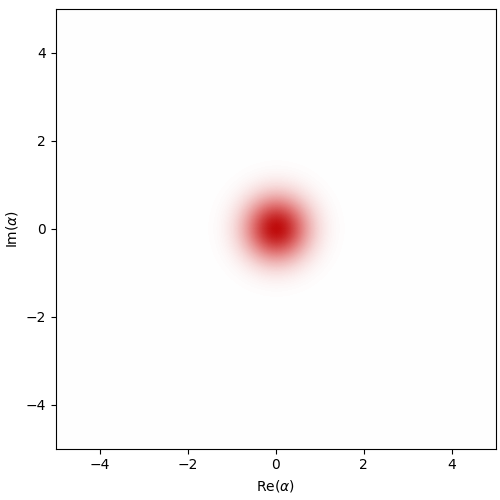

In [4]:
# Define the args dictionary with Gaussian envelope parameters
args2 = {
    'A_cavity': 100e6*(2*np.pi),  # Amplitude for cavity
    'w_cavity': w_c,  
    'phi_cavity': -np.pi/2,
    'flat_time_cavity': 3e-9*1.065*np.sqrt(2),       # flat-top
    'slope_time_cavity': 0e-9,      # slope
}

rho0 = H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag()  # vacuum(X)excited
time_drive = 5e-9
tlist = np.linspace(0, time_drive, 1000)

#total Hamiltonian
H = [H0 , [H_drive_cavity, envelope_cavity]]


# Solve the system with the time-dependent Hamiltoniaan
Urot = propagator(-H0, tlist, [], args={})
result = mesolve(H, rho0, tlist, c_ops, args=args2)
state_rf = [Urot[k]*result.states[k] for k in range(len(tlist))] #rotating frame (bare energy)
rho1 = state_rf[-1]

# Perform partial trace to get the cavity's reduced density matrix (tracing out qubit and resonator)
total_dm = [state_rf[k]*state_rf[k].dag() for k in range(len(tlist))]
cavity_dm_full = [ptrace(state_rf[k]*state_rf[k].dag(), 0) for k in range(len(tlist))]  # 0 refers to the cavity subsystem
cavity_dm_last = cavity_dm_full[-1]

dq.plot.wigner_gif(cavity_dm_full, fps=10, gif_duration=5.0)

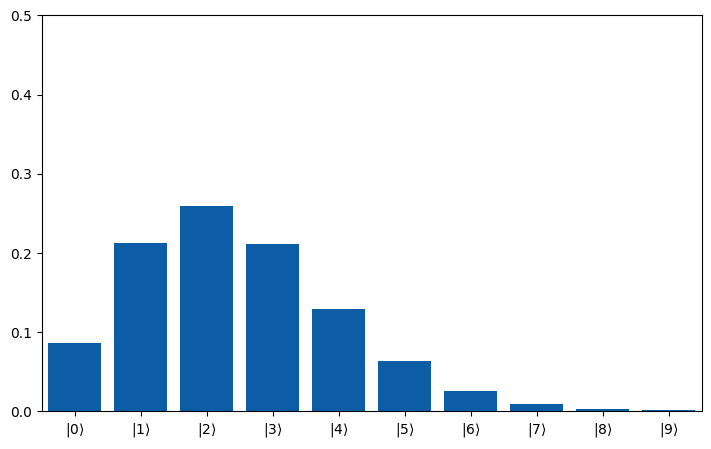

In [5]:
dq.plot.fock(cavity_dm_last, ymax=0.5)

100%|██████████| 50/50 [00:03<00:00, 16.46it/s]


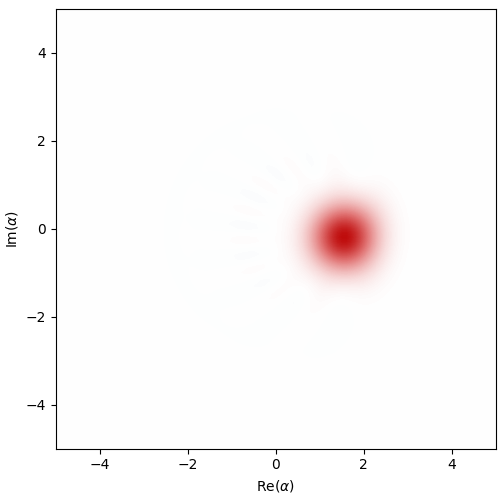

In [6]:
# Define the args dictionary with Gaussian envelope parameters
A = (2*np.pi)*1e6
args2 = {
    'A_qubit': A,   # Amplitude for qubit
    'w_qubit': w_q,  
    'phi_qubit':0,
    'flat_time_qubit': np.pi/A,       # flat-top
    'slope_time_qubit': 0e-9,         # slope

    'A_qubit_2nd': A,   # Amplitude for qubit
    'w_qubit_2nd': w_q+2*chi_cq,  
    'phi_qubit_2nd':0,
    'flat_time_qubit_2nd': np.pi/A,       # flat-top
    'slope_time_qubit_2nd': 0e-9,         # slope

    'A_qubit_3rd': A,   # Amplitude for qubit
    'w_qubit_3rd': w_q+3*chi_cq,  
    'phi_qubit_3rd':0,
    'flat_time_qubit_3rd': np.pi/A,       # flat-top
    'slope_time_qubit_3rd': 0e-9,         # slope

    'A_qubit_4th': A,   # Amplitude for qubit
    'w_qubit_4th': w_q+4*chi_cq,
    'phi_qubit_4th':0,
    'flat_time_qubit_4th': np.pi/A,       # flat-top
    'slope_time_qubit_4th': 0e-9,         # slope   

    'A_qubit_5th': A,   # Amplitude for qubit
    'w_qubit_5th': w_q+5*chi_cq,
    'phi_qubit_5th':0,
    'flat_time_qubit_5th': np.pi/A,       # flat-top
    'slope_time_qubit_5th': 0e-9         # slope
}


time_drive = np.pi/A
tlist = np.linspace(0, time_drive, 3000)

#total Hamiltonian
H = [ H0 , [H_drive_qubit, envelope_qubit], 
    #  [H_drive_qubit, envelope_qubit_2nd], [H_drive_qubit, envelope_qubit_3rd],
    #  [H_drive_qubit, envelope_qubit_4th], [H_drive_qubit, envelope_qubit_5th],
     ]


# Solve the system with the time-dependent Hamiltoniaan
Urot = propagator(-H0, tlist, [], args={})
result = mesolve(H, rho1, tlist, c_ops, args=args2)
state_rf = [Urot[k]*result.states[k] for k in range(len(tlist))] #rotating frame (bare energy)
rho2 = state_rf[-1]

# Perform partial trace to get the cavity's reduced density matrix (tracing out qubit and resonator)
total_dm = [state_rf[k]*state_rf[k].dag() for k in range(len(tlist))]
cavity_dm_full = [ptrace(state_rf[k]*state_rf[k].dag(), 0) for k in range(len(tlist))]  # 0 refers to the cavity subsystem
cavity_dm_last = cavity_dm_full[-1]

dq.plot.wigner_gif(cavity_dm_full, fps=10, gif_duration=5.0)

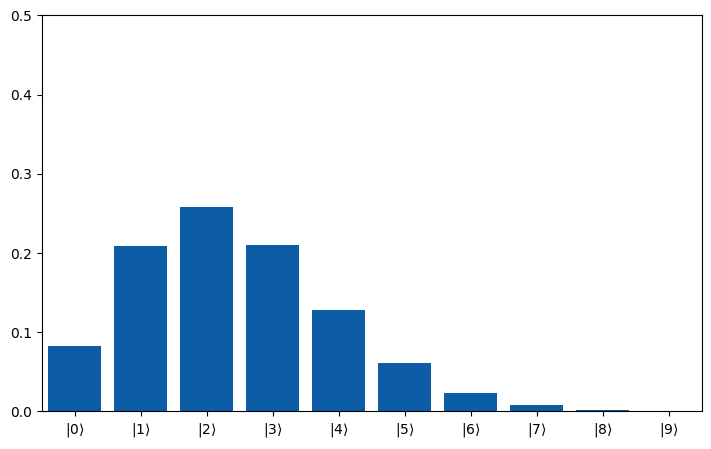

In [7]:
dq.plot.fock(cavity_dm_last, ymax=0.5)

In [8]:
qubit_dm_full = [ptrace(state_rf[k]*state_rf[k].dag(), 1) for k in range(len(tlist))]
qubit_dm_truncated = np.array([[[qubit_dm_full[k][0][0][0], qubit_dm_full[k][0][0][1]], [qubit_dm_full[k][1][0][0], qubit_dm_full[k][1][0][1]]] for k in range(len(tlist))])

qv.display_bloch_sphere_from_density_matrices(qubit_dm_truncated)

<IPython.core.display.Javascript object>

100%|██████████| 50/50 [00:02<00:00, 21.75it/s]


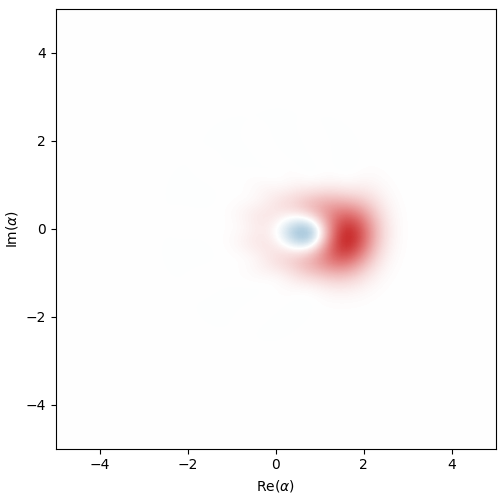

In [9]:
# Define the args dictionary with Gaussian envelope parameters
A = (2*np.pi)*1e6
args2 = {
    'A_qubit': A,   # Amplitude for qubit
    'w_qubit': w_q,  
    'phi_qubit':0,
    'flat_time_qubit': np.pi/A,       # flat-top
    'slope_time_qubit': 0e-9,         # slope

    'A_qubit_2nd': A,   # Amplitude for qubit
    'w_qubit_2nd': w_q+2*chi_cq,  
    'phi_qubit_2nd':0,
    'flat_time_qubit_2nd': np.pi/A,       # flat-top
    'slope_time_qubit_2nd': 0e-9,         # slope

    'A_qubit_3rd': A,   # Amplitude for qubit
    'w_qubit_3rd': w_q+3*chi_cq,  
    'phi_qubit_3rd':0,
    'flat_time_qubit_3rd': np.pi/A,       # flat-top
    'slope_time_qubit_3rd': 0e-9,         # slope

    'A_qubit_4th': A,   # Amplitude for qubit
    'w_qubit_4th': w_q+4*chi_cq,
    'phi_qubit_4th':0,
    'flat_time_qubit_4th': np.pi/A,       # flat-top
    'slope_time_qubit_4th': 0e-9,         # slope   

    'A_qubit_5th': A,   # Amplitude for qubit
    'w_qubit_5th': w_q+5*chi_cq,
    'phi_qubit_5th':0,
    'flat_time_qubit_5th': np.pi/A,       # flat-top
    'slope_time_qubit_5th': 0e-9         # slope
}


time_drive = np.pi/A
tlist = np.linspace(0, time_drive, 3000)

#total Hamiltonian
H = [ H0 , [H_drive_qubit, envelope_qubit], 
    #  [H_drive_qubit, envelope_qubit_2nd], [H_drive_qubit, envelope_qubit_3rd],
    #  [H_drive_qubit, envelope_qubit_4th], [H_drive_qubit, envelope_qubit_5th],
     ]


# Solve the system with the time-dependent Hamiltoniaan
Urot = propagator(-H0, tlist, [], args={})
result = mesolve(H, rho2, tlist, c_ops, args=args2)
state_rf = [Urot[k]*result.states[k] for k in range(len(tlist))] #rotating frame (bare energy)
rho3 = state_rf[-1]

# Perform partial trace to get the cavity's reduced density matrix (tracing out qubit and resonator)
total_dm = [state_rf[k]*state_rf[k].dag() for k in range(len(tlist))]
cavity_dm_full = [ptrace(state_rf[k]*state_rf[k].dag(), 0) for k in range(len(tlist))]  # 0 refers to the cavity subsystem
cavity_dm_last = cavity_dm_full[-1]

dq.plot.wigner_gif(cavity_dm_full, fps=10, gif_duration=5.0)

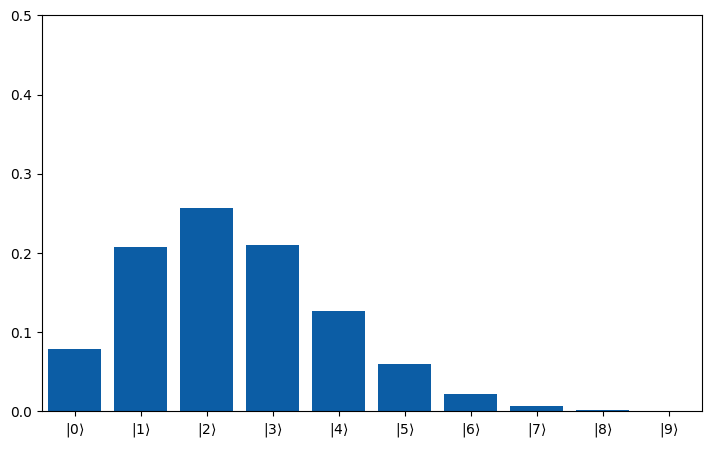

In [10]:
dq.plot.fock(cavity_dm_last, ymax=0.5)

In [11]:
qubit_dm_full = [ptrace(state_rf[k]*state_rf[k].dag(), 1) for k in range(len(tlist))]
qubit_dm_truncated = np.array([[[qubit_dm_full[k][0][0][0], qubit_dm_full[k][0][0][1]], [qubit_dm_full[k][1][0][0], qubit_dm_full[k][1][0][1]]] for k in range(len(tlist))])

qv.display_bloch_sphere_from_density_matrices(qubit_dm_truncated)

<IPython.core.display.Javascript object>

100%|██████████| 50/50 [00:01<00:00, 25.02it/s]


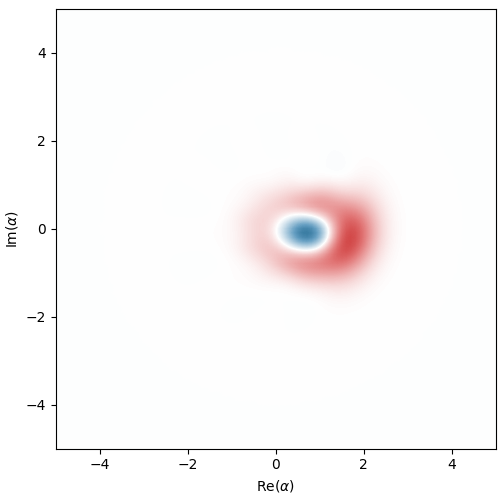

In [17]:
# Calculate the transition frequencies
w_eg = (H0.eigenenergies()[1] - H0.eigenenergies()[0] )
w_c_01 = (H0.eigenenergies()[2] - H0.eigenenergies()[0] )

# Define the args dictionary with Gaussian envelope parameters
args2 = {
    'A_qubit': (2*np.pi)*0e6,   # Amplitude for qubit
    'w_qubit': w_eg,   # Carrier frequency for qubit (5 GHz)
    'phi_qubit': 0,
    'flat_time_qubit': 5e-9,       # flat-top
    'slope_time_qubit': 0e-9,      # slope

    'A_cavity': 50e6*(2*np.pi),  # Amplitude for cavity
    'w_cavity': w_c_01,  
    'phi_cavity': +np.pi/2,
    'flat_time_cavity': 3e-9*1.065*np.sqrt(2),       # flat-top
    'slope_time_cavity': 0e-9,      # slope
}

# rho0 = state_rf[-1]
rho0 = H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag()  # vacuum(X)excited
time_drive = 4e-9
tlist = np.linspace(0, time_drive, 1000)

#total Hamiltonian
H = [H0 , [H_drive_qubit, envelope_qubit], [H_drive_cavity, envelope_cavity]]


# Solve the system with the time-dependent Hamiltoniaan
Urot = propagator(-H0, tlist, [], args={})
result = mesolve(H, rho3, tlist, c_ops, args=args2)
state_rf = [Urot[k]*result.states[k] for k in range(len(tlist))] #rotating frame (bare energy)

# Perform partial trace to get the cavity's reduced density matrix (tracing out qubit and resonator)
total_dm = [state_rf[k]*state_rf[k].dag() for k in range(len(tlist))]
cavity_dm_full = [ptrace(state_rf[k]*state_rf[k].dag(), 0) for k in range(len(tlist))]  # 0 refers to the cavity subsystem
cavity_dm_last = cavity_dm_full[-1]

dq.plot.wigner_gif(cavity_dm_full, fps=10, gif_duration=5.0)

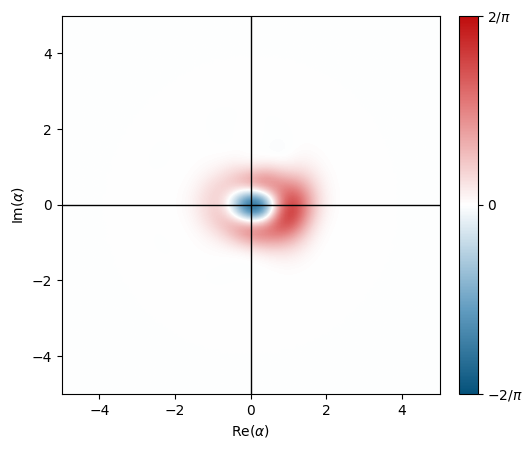

In [18]:
dq.plot.wigner(cavity_dm_last)
plt.axvline(0, color='black', lw=1)
plt.axhline(0, color='black', lw=1)

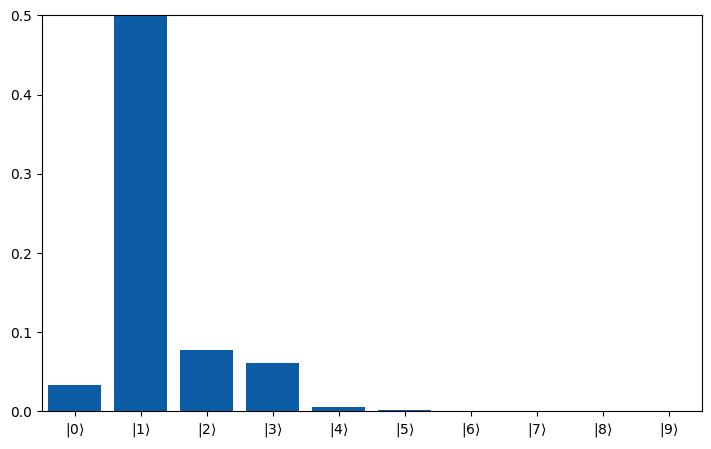

In [19]:
dq.plot.fock(cavity_dm_last, ymax=0.5)

In [20]:
fidelity(cavity_dm_last, fock(10,1))

0.8882016085763941